## Run MCMC inference using GP model

In [1]:
import random
import time

import tikzplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
import pickle

import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE.priors import Matern12 #, Matern52, SquaredExponential
from experiments.zimbabwe.zimbabwe_utility import read_data

numpyro.set_host_device_count(4)

In [2]:
data_path = "../data/zwe2016phia.geojson"
num_warmup = 2000
num_samples = 10000
num_chains = 2

## Load Data

In [3]:
import os
os.getcwd()

'/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe/notebooks'

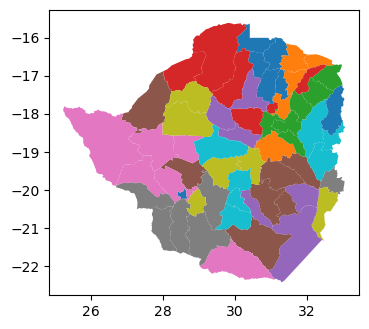

In [6]:
data = gpd.read_file(data_path)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data.plot(column='area_id', ax=ax, legend=False)

plt.show()

In [14]:
x, data_centroid = read_data(data_path, normalize=True)

/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


In [15]:
## Adding estimate data
data_centroid["estimate"] = data["estimate"]

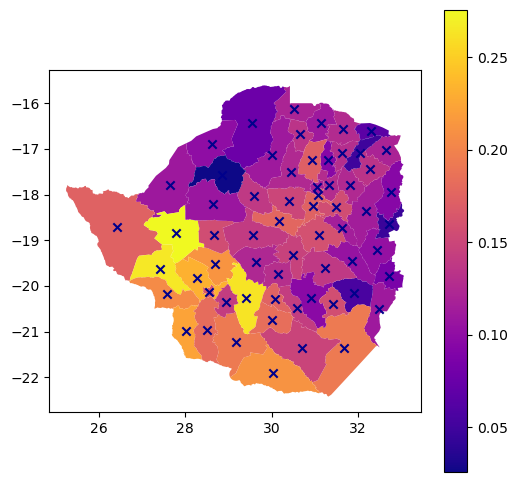

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
data_centroid.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
data_centroid["centroid"].plot(ax=ax, color="DarkBlue", marker="x")
plt.show()

In [34]:
#def model_centroids(x, n_obs=None, kernel=Matern52(), y=None):
def model_centroids(x, n_obs=None, kernel=Matern12(), y=None):
    
    # fixed effects
    #b0 = numpyro.sample('b0', npdist.Normal(0, 1))
     
    #lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2,4)) 
    lengthscale = numpyro.sample("lengthscale", npdist.Uniform(0,1)) 
    kernel.lengthscale = lengthscale
    k = kernel(x, x)
    
    #kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    kernel_var = 0.77
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    # linear predictor
    #lp = b0 + re
    lp = re
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

## Observations

In [35]:
data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

## GP Prior

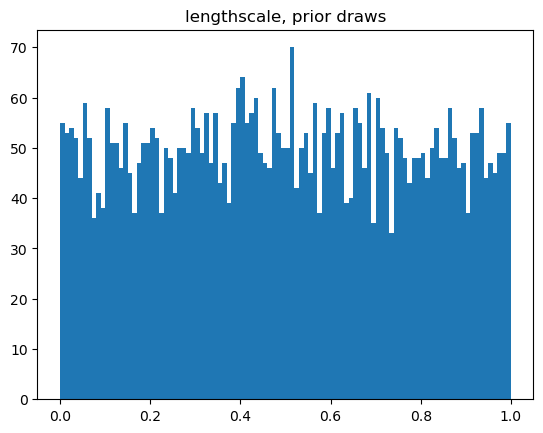

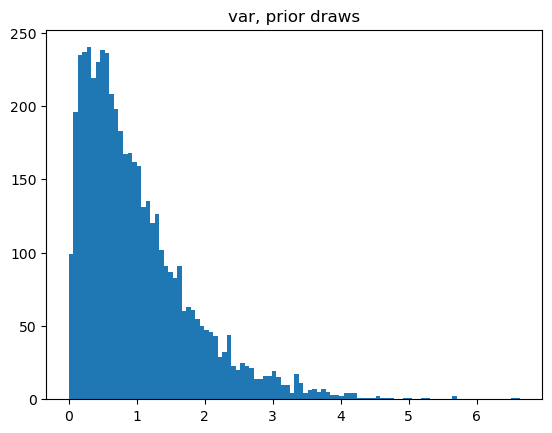

In [36]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_centroids, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['lengthscale']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['variance']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

## MCMC Inference using GP Prior

In [37]:
fname = 'mcmc_fits/zimbabwe_gp_mcmc_Matern12_Uniform.pkl'

rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

# inference
start = time.time()
kernel = NUTS(model_centroids)
mcmc_gp = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_gp.run(rng_key, x=x, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
t_elapsed = time.time() - start

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [38]:
#with open(fname, 'wb') as f:
#    pickle.dump(mcmc_gp, f)

In [39]:
import os
os.getcwd()

'/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe/notebooks'

In [40]:
fname

'mcmc_fits/zimbabwe_gp_mcmc_Matern12_Uniform.pkl'

In [41]:
mcmc_gp.print_summary(exclude_deterministic=True)
mcmc_gp_samples = mcmc_gp.get_samples()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.91      0.08      0.93      0.79      1.00   8275.21      1.00
    re_std[0]     -2.13      0.27     -2.11     -2.57     -1.68    436.96      1.00
    re_std[1]     -2.35      0.33     -2.33     -2.89     -1.79    487.14      1.00
    re_std[2]     -2.59      0.32     -2.58     -3.13     -2.06    430.28      1.00
    re_std[3]     -2.82      0.40     -2.80     -3.47     -2.17    521.67      1.00
    re_std[4]     -3.01      0.44     -2.99     -3.74     -2.31    622.61      1.00
    re_std[5]     -2.74      0.38     -2.72     -3.36     -2.11    538.36      1.00
    re_std[6]     -2.75      0.38     -2.73     -3.38     -2.13    501.91      1.00
    re_std[7]     -2.92      0.39     -2.90     -3.54     -2.25    480.79      1.00
    re_std[8]     -3.19      0.44     -3.17     -3.91     -2.47    652.13      1.00
    re_std[9]     -2.89      0.44     -2.87     -3.60     -2.14    662.32  

In [42]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 94 s
Average ESS for all REs : 25089


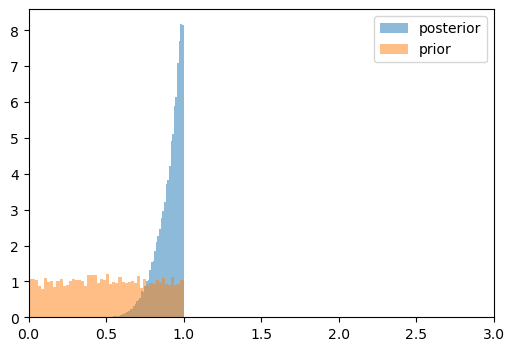

In [43]:
c_samps_gp = mcmc_gp_samples['lengthscale']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
plt.xlim([0, 3])

tikzplotlib.save(r"lengthscale.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

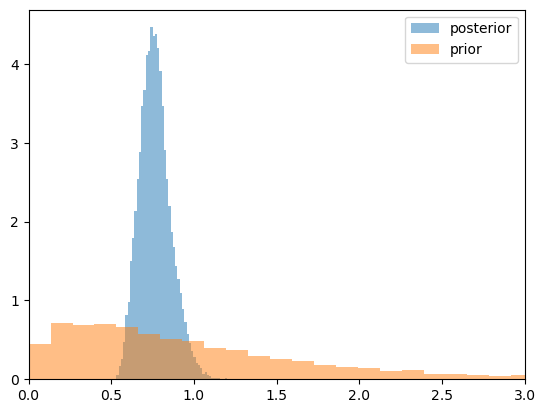

In [44]:
var_samps_gp = mcmc_gp_samples['variance']
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

tikzplotlib.save(r"variance.tex",
                 figurewidth='\\figurewidth', figureheight='\\figureheight',
                 figure=fig)

plt.show()

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

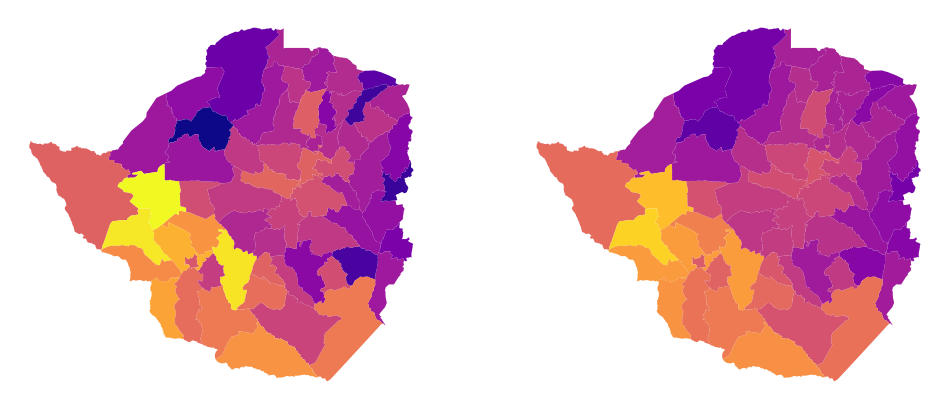

In [45]:
# posterior predictive
posterior_predictive = Predictive(model_centroids, mcmc_gp_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
                                                                         x=x, 
                                                                         n_obs = jnp.array(data.n_obs))


theta_samps_gp = posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = jnp.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = jnp.quantile(theta_samps_gp, 0.75, axis=0)

data['theta_gp'] = theta_mean_gp

theta_observed = jnp.array(data['estimate'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
data.plot(column="estimate", ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")

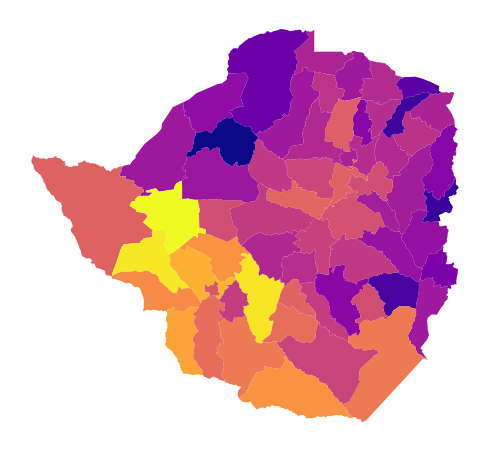

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")
plt.tight_layout()
plt.savefig("estimate.pdf")
plt.show()

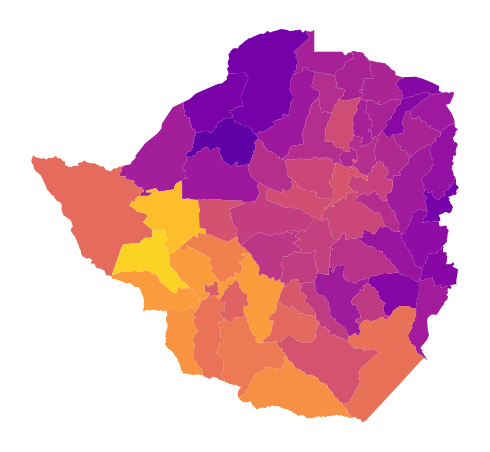

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(column="theta_gp", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")
plt.tight_layout()
plt.savefig("gp_inference.pdf")
plt.show()